In [1]:
import pandas as pd
import cufflinks as cf
import plotly.offline
import plotly.graph_objs as go  
import mytools.regression as reg
import mytools.date as dt
import mytools.plot as mpl

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Italian intensive care cases 

In [2]:
# loading the data
df = pd.read_csv('italy-intensive_care.csv')
a = list((dt.day_of_year_to_date(v)).strftime("%d %b") for v in df['day'])
df.index = a
# display the table
pd.DataFrame(df['intensive care'])



,intensive care
24 Feb,27
25 Feb,35
26 Feb,36
27 Feb,56
28 Feb,64
29 Feb,105
01 Mar,140
02 Mar,166
03 Mar,229
04 Mar,295


## Fitting intensive care data with exponential and logistic models

The exponential model is:

$$y = e^{k(x-x_0)} + y_0$$

where $k, x_0, y_0$ are the parameters to estimate.

For the logistic model:

$$y = \frac{c}{1+e^{-k(x-x_0)}} + y_0$$

where $c, k, x_0, y_0$ are the parameters to estimate.

In [3]:
x_orig = df['day']
y_orig = df['intensive care']

sigm_model, xp, pxp = reg.fit_sigmoid(x_orig, y_orig, verbose=True)
flex = reg.sigmoid_get_flex(sigm_model)

exp_model, exp_xp, exp_pxp = reg.fit_exponential(x_orig, y_orig, upper=1.25, verbose=True)

log_model, log_xp, log_pxp = reg.fit_logistic_distribution(x_orig, y_orig, verbose=True)
peak = reg.logistic_distribution_get_max(log_model)

`gtol` termination condition is satisfied.
Function evaluations 24, initial cost 1.9298e+00, final cost 5.1451e-04, first-order optimality 6.85e-09.
[1.03049815 0.2611233  1.5945852  5.42441978]
24 Feb    0.009122
25 Feb    0.006444
26 Feb   -0.000871
27 Feb   -0.000883
28 Feb   -0.008455
29 Feb   -0.002817
01 Mar   -0.002681
02 Mar   -0.009907
03 Mar   -0.003388
04 Mar    0.000394
05 Mar   -0.005190
06 Mar    0.009872
07 Mar    0.016501
08 Mar    0.006855
09 Mar   -0.008892
10 Mar   -0.002030
11 Mar    0.002442
12 Mar   -0.010301
13 Mar   -0.003597
14 Mar    0.007384
dtype: float64
std err: 0.007173070271871418
        Sigmoid model
        x0 = 74.82780694245547
        y0 = -55.80737098691642
        c = 3396.466481850007
        k = 0.19984704447128623
        asymptot = 3340.6591108630905
        flex = 74.82780694245547, 1642.425869938087
        
[0.65       0.43896714 1.        ]
`gtol` termination condition is satisfied.
Function evaluations 14, initial cost 7.5110e+00, final 

In [4]:
# preparing table with predictions
d_max = df['day'].max()
d_min = df['day'].min()

f_days_exp = range(d_min - 4, d_max + 4, 1)
f_days_sigm = range(d_min - 4, d_max + 20, 1)
f_days_log = range(d_min - 4, d_max + 20, 1)

f_exp = reg.exponential(exp_model, f_days_exp)
f_sigm = reg.sigmoid(sigm_model, f_days_sigm)
f_log = reg.logistic_distribution(log_model, f_days_log)
f_df_exp = pd.DataFrame({'day' : f_days_exp, 'exp' : f_exp})
f_df_sigm = pd.DataFrame({'day' : f_days_sigm, 'sigm' : f_sigm})
f_df_log = pd.DataFrame({'day' : f_days_log, 'log' : f_log})
f_df_exp.index = dt.day_of_year_to_string(f_days_exp)
f_df_sigm.index = dt.day_of_year_to_string(f_days_sigm)
f_df_log.index = dt.day_of_year_to_string(f_days_log)

df_final = pd.merge(df, f_df_exp, on='day', how='outer', sort=True).merge(f_df_sigm, on='day', how='outer', sort=True).merge(f_df_log, on='day', how='outer', sort=True)
df_final.index = dt.day_of_year_to_string(f_days_sigm)
df_final

,day,intensive care,exp,sigm,log
20 Feb,51,NaN,-76.160114,-27.016417,-32.556227
21 Feb,52,NaN,-63.703489,-20.713207,-25.544427
22 Feb,53,NaN,-49.560327,-13.047555,-17.119804
23 Feb,54,NaN,-33.502284,-3.733428,-7.004705
24 Feb,55,27.0,-15.270098,7.571202,5.129934
25 Feb,56,35.0,5.430594,21.273370,19.672687
26 Feb,57,36.0,28.934008,37.854642,37.080347
27 Feb,58,56.0,55.619615,57.880640,57.886949
28 Feb,59,64.0,85.918259,82.009756,82.712584
29 Feb,60,105.0,120.319120,110.999810,112.271178


In [5]:
fig = df_final[['exp', 'sigm', 'log', 'intensive care']].iplot(theme="white", title="Intensive care cases", size=4, yTitle='cases', mode='lines+markers', asFigure=True)
fig.data[3].mode='markers'
fig.data[3].marker.size = 8
fig.add_trace(go.Scatter(x=[dt.day_of_year_to_string(round(flex[0]))], y=[flex[1]], name='flex', mode="markers"))
fig.add_trace(go.Scatter(x=[dt.day_of_year_to_string(round(peak[0]))], y=[peak[1]], name='peak', mode="markers"))
fig.data[4].marker.size = 8
fig.data[4].marker.color = 'rgba(255, 0, 0, 125)'
fig.data[5].marker.size = 8
# days = df_final.index.to_list()
# 
# fig.update_layout(
#     xaxis=dict(
#         tickmode='array',
#         tickvals=dt.str_to_day_of_year([d +' 2020' for d in days], '%d %b %Y'),
#         ticktext=days,
#         tickangle=90
#     )
# )
fig = mpl.iplot_add_log_scale_button(fig)
fig.show()

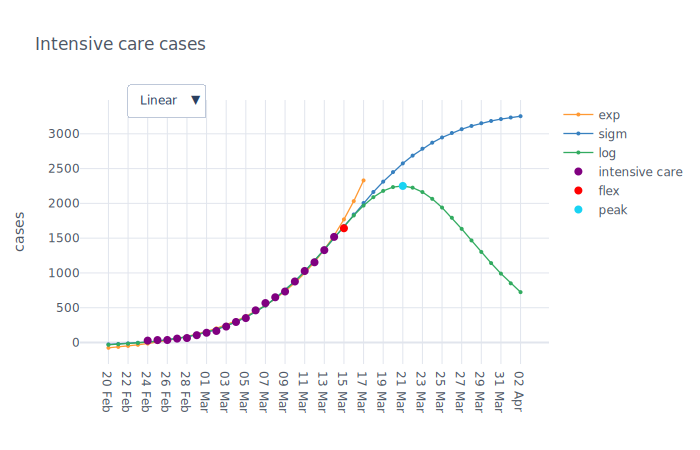

In [6]:
fig.show('svg')